In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import numpy_groupies as npg

import itertools

import scipy as sp
import scipy.signal

import itertools
import pickle
import glob
import os
import re 

import tqdm.notebook as tqdm

import networkx as nx

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from collections import defaultdict

from utils.pac import morph_cohort_pac_heatmap, PacSignificanceFunctor, morph_electrode_counter, compute_noise_with_notch
from utils.surf import create_adjacency, create_distance_matrix, convert_matrix_indices, smooth_adjacent_values
from utils.vis_3d import BrainSurface
from utils.stats import bootstrap_statistic, nanpearson
from utils.burst import acf_mass_ratio, acf_magnitude
from utils.pyutils import reorder, get_subsystem_hemi, create_subsystem_map, convert_to_array
from utils.io import read_seeg_parcel_names, fix_mop, is_bipolar
from utils.colors import ripples_blue, ripples_red

from crosspy.core.autocorrelation import get_length_by_cdf, get_length_by_mean

%config InlineBackend.figure_format = 'jpg'

In [3]:
def find_longest_segment(arr, min_length=5):
    indices = np.where(np.diff(arr))[0]

    start_indices = indices[::2]
    end_indices = indices[1::2]
    
    max_len = min(len(start_indices), len(end_indices))
    
    if max_len == 0:
        return None
    
    best_idx = np.argmax(end_indices[:max_len] - start_indices[:max_len])
    start = start_indices[best_idx]
    end = end_indices[best_idx]

    if (end - start < min_length):
        return None
    
    return np.arange(start, end + 1)

def compute_e_values(arr, threshold, min_length=10, percentiles=np.array([0.25, 0.5, 0.75])):
    mask = (arr >= threshold)

    segment_indices = find_longest_segment(mask, min_length=min_length)

    if (segment_indices is None):
        return None

    segment = arr[segment_indices].copy()
    segment /= segment.sum()
    segment_sum = np.cumsum(segment)

    e_values = np.abs(segment_sum.reshape(1,-1) - percentiles.reshape(-1,1)).argmin(axis=-1)

    return e_values

def acf_mass_ratio(arr, percentiles=np.array([0.25, 0.5, 0.75]), threshold=2.42, min_length=10):
    e_values = compute_e_values(arr, threshold=threshold, min_length=min_length, percentiles=percentiles)

    if (e_values is None):
        return np.nan
    
    # offset = np.argmax(arr >= threshold)
    # peak_idx = arr.argmax() - offset + 1
    
    return (e_values[2] - e_values[1])/(e_values[1] - e_values[0])
    # return (e_values[2] + e_values[0] - 2*e_values[1])/(e_values[2] - e_values[0])

    # return (e_values[2] - peak_idx - peak_idx + e_values[0])/(e_values[2] - e_values[0])
    # return (e_values[2] + e_values[0] - 2*e_values[1])/(e_values[2] - e_values[0])

In [4]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
okabe = [ "#0072B2", "#D55E00","#CC79A7", "#009E73",  "#E69F00", "#56B4E9",    "#F0E442",  "#000000"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

data_color = okabe[0]
noise_color = okabe[7]
red_color = okabe[2]
orange_color = okabe[1]
green_color = okabe[3]

In [5]:
meg_path = r'L:\nttk-data3\palva\Vlad\pac_meg_controls_rs_omega_7.5_signal_freq'
meg_files = glob.glob(meg_path + '\\*_parcels.pickle')

In [6]:
meg_data_nsamples = pickle.load(open('meg_data_nsamples.pickle', 'rb'))
seeg_data_nsamples = pickle.load(open('seeg_data_nsamples.pickle', 'rb'))

noise_pacf_by_ncycles = np.load('noise_pacf_by_ncycles.npy')

In [7]:
seeg_parcel_names = read_seeg_parcel_names(400)
unk_idx = [idx for (idx, n) in enumerate(seeg_parcel_names[-402:]) if ('unknown' in n.lower()) or ('background' in n.lower())]

In [8]:
f_vals = [2]

while f_vals[~0] < 99:
    f_vals.append(f_vals[~0]*1.05)

f_vals = np.array(f_vals)

lags_cycles = np.arange(0,20,0.1)

meg_noise_with_notch = np.load('meg_noise_level.npy')

In [9]:
meg_burst_coeffs = np.zeros((len(meg_files), len(f_vals), 400))
meg_acf_magnitude = np.zeros((len(meg_files), len(f_vals), 400))
meg_burst_acfs = np.zeros((len(meg_files), len(f_vals), 400, 200))

for subj_idx, fname in enumerate(tqdm.tqdm(meg_files)):
    subj_fdata = pickle.load(open(fname, 'rb'))
    subj_ns = [meg_data_nsamples[n] for n in subj_fdata['good_data_names']]
    
    subj_cycles_per_freq = [np.clip(np.rint(ns*f_vals/1000).astype(int), a_min=None, a_max=49999) for ns in subj_ns]
    
    subj_noise_pacf = np.array([noise_pacf_by_ncycles[cycles_per_freq, None] for cycles_per_freq in subj_cycles_per_freq])
    subj_pacf_lengths = np.apply_along_axis(get_length_by_cdf, -1, subj_fdata['pac'], lags_cycles, 0.9)
    
    subj_burst_acfs = subj_fdata['pac'] / subj_noise_pacf                
    meg_burst_acfs[subj_idx] = np.nanmean(subj_burst_acfs, axis=0)
    
#     recordings_burst_coeffs = np.apply_along_axis(acf_significance_width, -1, subj_burst_acfs)
    recordings_burst_coeffs = np.apply_along_axis(acf_mass_ratio, -1, subj_burst_acfs, threshold=1.75)
#     recordings_burst_coeffs = np.apply_along_axis(acf_burst_ratio, -1, subj_burst_acfs)
    # recordings_burst_magnitude = np.apply_along_axis(acf_magnitude, -1, subj_burst_acfs)
    
    non_sign_mask = (subj_pacf_lengths <= meg_noise_with_notch[None,:,None])
    recordings_burst_coeffs[non_sign_mask] = np.nan
    # recordings_burst_magnitude[non_sign_mask] = np.nan
    
    meg_burst_coeffs[subj_idx] = np.nanmean(recordings_burst_coeffs, axis=0)
    # meg_acf_magnitude[subj_idx] = np.nanmean(recordings_burst_magnitude, axis=0)

avg_meg_burst_coeffs = np.nanmean(meg_burst_coeffs, axis=0)

  0%|          | 0/54 [00:00<?, ?it/s]

d:\ProgramData\anaconda3\envs\seeg_meso_env\lib\site-packages\crosspy-0.0.1b0-py3.10.egg\crosspy\core\autocorrelation.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\4035004204.py:26: RuntimeWarning: Mean of empty slice
  meg_burst_coeffs[subj_idx] = np.nanmean(recordings_burst_coeffs, axis=0)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\4035004204.py:29: RuntimeWarning: Mean of empty slice
  avg_meg_burst_coeffs = np.nanmean(meg_burst_coeffs, axis=0)


In [10]:
def compute_stable_fraction(arr, axis=0):
    res = (arr > 1.05).astype(float)
    res[np.isnan(arr)] = np.nan

    return np.nanmean(res, axis=axis)

def compute_burst_fraction(arr, axis=0):
    res = (arr < 0.95).astype(float)
    res[np.isnan(arr)] = np.nan

    return np.nanmean(res, axis=axis)

meg_burst_coeffs_boot = np.zeros((1000, *meg_burst_coeffs.shape[1:]))
meg_stable_fraction_boot = np.zeros((1000, *meg_burst_coeffs.shape[1:]))
meg_burst_fraction_boot = np.zeros((1000, *meg_burst_coeffs.shape[1:]))

for i in range(1000):
    round_indices = np.random.choice(np.arange(meg_burst_coeffs.shape[0]), size=meg_burst_coeffs.shape[0])
    
    meg_burst_coeffs_boot[i] = np.nanmean(meg_burst_coeffs[round_indices], axis=0)
    meg_stable_fraction_boot[i] = compute_stable_fraction(meg_burst_coeffs[round_indices], axis=0)
    meg_burst_fraction_boot[i] = compute_burst_fraction(meg_burst_coeffs[round_indices], axis=0)


C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\172223407.py:20: RuntimeWarning: Mean of empty slice
  meg_burst_coeffs_boot[i] = np.nanmean(meg_burst_coeffs[round_indices], axis=0)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\172223407.py:5: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, axis=axis)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\172223407.py:11: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, axis=axis)


In [11]:
bad_subjects = ['02', # weird mop
                '06',
                '40',
                '42',
                '57',
                '60',# too short
               ] 

meta_data_subjects = pickle.load(open('meso_data/meta_data_subjects.pickle', 'rb'))

In [12]:
res_path = os.path.join('meso_data', 'pac_signal_frequency_7.5', 'pac_sub*.pickle')
res_files = glob.glob(res_path)

print(len(res_files))

68


In [13]:
cohort_pacf_lifetime = list()
cohort_noise_lifetime = list()
cohort_pacfs = list()
cohort_parcels = list()
cohort_acfs = list()

for fname in res_files:
    base_name = os.path.split(fname)[~0]
    subj_num = re.findall(r'\d+', base_name)[0]
    
    if subj_num in  bad_subjects:
        print('passing', subj_num)
        continue
    
    subj_montage = meta_data_subjects[subj_num]['montage']
    bipolar_mask = subj_montage['name'].apply(is_bipolar)
    subj_montage = subj_montage[bipolar_mask]
    subj_chans = subj_montage['name'].tolist()
    
    subj_mop = fix_mop(meta_data_subjects[subj_num]['mop'], bipolar_mask)
    subj_parcels = subj_mop['parcel_assign']
    
    subj_res = pickle.load(open(fname, 'rb'))
    f_vals = np.array(subj_res['f_vals'])
    
    if subj_res['data_pac'].shape[1] != subj_montage.shape[0] or subj_num in bad_subjects:
        print('passing', subj_num)
        continue
        
    if np.array_equal(subj_chans, subj_mop['channel_names']) == False:
        index_mapper = [subj_chans.index(n) for n in subj_mop['channel_names']]
        subj_parcels = subj_parcels[index_mapper]

    
    subj_lengths_channelwise = np.array([np.apply_along_axis(lambda arr: get_length_by_cdf(arr, lags_cycles, 0.9), 1, pac)
                                        for pac in subj_res['data_pac']])

    subj_noise_lengths_channelwise = np.array([np.apply_along_axis(lambda arr: get_length_by_cdf(arr, lags_cycles, 0.9), 1, pac) 
                                        for pac in subj_res['noise_pac']])
    
    

    subj_ns = seeg_data_nsamples[f'sub-{subj_num}']
    subj_cycles_per_freq = np.clip(np.rint(subj_ns*f_vals/1000).astype(int), a_min=None, a_max=49999)
    subj_noise_pacf = noise_pacf_by_ncycles[subj_cycles_per_freq, None]

    subj_burst_acfs = subj_res['data_pac'] / subj_noise_pacf        
    
    cohort_pacfs.append(subj_res['data_pac'])
    cohort_pacf_lifetime.append(subj_lengths_channelwise)
    cohort_parcels.append(subj_parcels)
    cohort_acfs.append(subj_burst_acfs)
    cohort_noise_lifetime.append(subj_noise_lengths_channelwise)


passing 02
passing 06
passing 19
passing 40
passing 42
passing 57
passing 60


In [14]:
cohort_parcels = convert_to_array(cohort_parcels)

In [15]:
def morph_burst_heatmap(mop_assignment, values, n_parcels, functor=None):
    def _filter_unk(pair):
        return pair[0] != -1

    n_freqs = values.shape[0]
    
    counter = morph_electrode_counter(mop_assignment, n_parcels)
    counter = np.tile(counter, (n_freqs, 1)).T
    
    res = np.zeros((n_parcels, n_freqs))
    
    for (parcel, spectrum) in filter(_filter_unk, zip(mop_assignment, values.T.copy())):
        if functor:
            spectrum = functor(spectrum)
        
        nan_mask = np.isnan(spectrum)
        finite_mask = ~nan_mask

        res[parcel, finite_mask] += spectrum[finite_mask]
        counter[parcel, nan_mask] -= 1

    res /= counter
    
    return res

def morph_cohort_burst_heatmap(cohort_mops, cohort_values, n_parcels, functor=None):
    n_subjs = len(cohort_mops)
    n_freqs = cohort_values[0].shape[0]
    
    res = np.zeros((n_subjs, n_parcels, n_freqs))
    
    for i in range(n_subjs):
        res[i] = morph_burst_heatmap(cohort_mops[i], cohort_values[i], n_parcels, functor=functor)
    
    return res

In [16]:
def compute_cohort_burst_coeffs(cohort_pacf_normed, cohort_pacf_lifetime, threshold=2, min_length=10):
    res = list()

    for subj_pacf_normed, subj_pacf_lifetime in zip(cohort_pacf_normed, cohort_pacf_lifetime):
        subj_res = np.zeros(subj_pacf_normed.shape[:-1])

        for freq_idx in range(subj_res.shape[0]):
            for chan_idx in range(subj_res.shape[1]):
                max_lag = int(subj_pacf_lifetime[freq_idx, chan_idx]*10)

                # if max_lag > 50:
                #     x = 42
                #     val = acf_mass_ratio(subj_pacf_normed[freq_idx, chan_idx, :max_lag*2], threshold=threshold, min_length=min_length)

                    
                subj_res[freq_idx, chan_idx] = acf_mass_ratio(subj_pacf_normed[freq_idx, chan_idx, :max_lag*2], threshold=threshold, min_length=min_length)

        res.append(subj_res)
    
    return convert_to_array(res)


In [17]:
noise_level = np.percentile(np.concatenate(cohort_noise_lifetime, axis=-1), 95, axis=-1)

cohort_burst_coeffs = convert_to_array([np.apply_along_axis(acf_mass_ratio, -1, subj_burst_acfs, threshold=1.75, min_length=5) for subj_burst_acfs in cohort_acfs])
# cohort_burst_coeffs = compute_cohort_burst_coeffs(cohort_acfs, cohort_pacf_lifetime)

for burst_coeffs, pacf_lifetime in zip(cohort_burst_coeffs, cohort_pacf_lifetime):
    sign_mask = (pacf_lifetime < noise_level.reshape(-1,1))
    burst_coeffs[sign_mask] = np.nan

In [18]:
cohort_seeg_burst_values = morph_cohort_burst_heatmap(cohort_parcels, cohort_burst_coeffs, n_parcels=400+93)

cohort_seeg_burst_known = np.delete(cohort_seeg_burst_values[:, -402:], unk_idx, axis=1)

known_burst_values = np.nanmean(cohort_seeg_burst_known, axis=0)

C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\751676158.py:22: RuntimeWarning: invalid value encountered in true_divide
  res /= counter
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\1037520276.py:5: RuntimeWarning: Mean of empty slice
  known_burst_values = np.nanmean(cohort_seeg_burst_known, axis=0)


In [19]:
n_cortical = 400

In [20]:
n_rounds = 1000
n_subjs = len(cohort_pacf_lifetime)

seeg_burst_values_boot = np.zeros((n_rounds, n_cortical, len(f_vals)))
seeg_stable_fraction_boot = np.zeros((n_rounds, n_cortical, len(f_vals)))
seeg_burst_fraction_boot = np.zeros((n_rounds, n_cortical, len(f_vals)))

for i in range(n_rounds):
    round_indices = np.random.choice(np.arange(n_subjs), size=n_subjs)

    round_seeg_burst_values = morph_cohort_pac_heatmap(cohort_parcels[round_indices], cohort_burst_coeffs[round_indices], n_parcels=n_cortical+93)
    round_seeg_burst_known = np.delete(round_seeg_burst_values[:, -402:], unk_idx, axis=1)

    seeg_burst_values_boot[i] = np.nanmean(round_seeg_burst_known, axis=0)

    round_stable_fraction = (round_seeg_burst_known > 1.05).astype(float)
    round_stable_fraction[np.isnan(round_seeg_burst_known)] = np.nan

    round_burst_fraction = (round_seeg_burst_known < 0.95).astype(float)
    round_burst_fraction[np.isnan(round_seeg_burst_known)] = np.nan

    seeg_stable_fraction_boot[i] = np.nanmean(round_stable_fraction, axis=0)
    seeg_burst_fraction_boot[i] = np.nanmean(round_burst_fraction, axis=0)


C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\2544839982.py:14: RuntimeWarning: Mean of empty slice
  seeg_burst_values_boot[i] = np.nanmean(round_seeg_burst_known, axis=0)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\2544839982.py:22: RuntimeWarning: Mean of empty slice
  seeg_stable_fraction_boot[i] = np.nanmean(round_stable_fraction, axis=0)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\2544839982.py:23: RuntimeWarning: Mean of empty slice
  seeg_burst_fraction_boot[i] = np.nanmean(round_burst_fraction, axis=0)


In [22]:
fsaverage_path = r'L:\nttk-data2\palva\Common repos\_fsaverage\fsaverage'

brain_surf_lh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['lh'], surface='inflated')
brain_surf_rh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['rh'], surface='inflated')

surf_3d_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]
brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]

In [23]:
meg_parcel_names = [n.strip()[:-3] for n in subj_fdata['channel_names']]
seeg_parcel_names = read_seeg_parcel_names(400)
seeg_parcel_names = np.delete(seeg_parcel_names[-402:], [0,201])

In [24]:
cortical_parcels = [n for n in seeg_parcel_names[-402:] if not('unknown' in n.lower() or 'background' in n.lower())]
cortical_subsystems = np.array([n.split('_')[2] for n in cortical_parcels])

# subsystem_to_index = {s:idx for (idx, s) in enumerate(set(cortical_subsystems))}
subsystem_to_index = create_subsystem_map(cortical_subsystems)
subsystem_indices = np.array([subsystem_to_index[s] for s in cortical_subsystems])

In [25]:
seeg_parcel_names_new = pickle.load(open('seeg_new_names_yeo17_400.pickle', 'rb'))

In [26]:
seeg_comm_to_nodes = pickle.load(open('meso_data/seeg_comm_to_nodes.pickle', 'rb'))
meg_comm_to_nodes = pickle.load(open('meso_data/meg_comm_to_nodes.pickle', 'rb'))

In [27]:
brain_surf_lh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['lh'], surface='inflated')
brain_surf_rh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['rh'], surface='inflated')

surf_3d_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]
brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]

In [28]:
def fix_limbic(n):
    if not('limbic' in n.lower()):
        return n
    
    if 'ofc' in n.lower():
        return n.replace('Limbic', 'LimbicB')
    else:
        return n.replace('Limbic', 'LimbicA')

In [29]:
surf_3d_parcel_names_limbic = [fix_limbic(n) for n in surf_3d_parcel_names]

In [30]:
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nib

In [32]:
if os.path.exists('known_burst_fraction_boot.npy'):
    known_burst_fraction_boot = np.load('known_burst_fraction_boot.npy')
else:
    print('wtf')

if os.path.exists('known_stable_fraction_boot.npy'):
    known_stable_fraction_boot = np.load('known_stable_fraction_boot.npy')
else:
    print('wtf')
    
    
if os.path.exists('known_burst_values.npy'):
    known_burst_values_orig = np.load('known_burst_values.npy')
    
counter_known = np.load('counter_known.npy')
adjacency_matrix = np.load('yeo17_400_adjacency_matrix.npy')

In [33]:
import string
from utils.plot import draw_four_views
from utils.vis_3d import BrainSurface

In [34]:
legend_elements = [
                   Patch(facecolor='orange', edgecolor='r',
                         label='Color Patch')]


In [35]:
seeg_communities_new = pickle.load(open('seeg_communities_new.pickle', 'rb'))
meg_communities_new = pickle.load(open('meg_communities_new.pickle', 'rb'))

In [36]:
avg_meg_burst_coeffs = np.nanmean(meg_burst_coeffs_boot, axis=0)

C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\2188963866.py:1: RuntimeWarning: Mean of empty slice
  avg_meg_burst_coeffs = np.nanmean(meg_burst_coeffs_boot, axis=0)


In [37]:
burst_coeff_examples = pickle.load(open('burst_coeff_example.pickle', 'rb'))

bursty_pacf_normed = burst_coeff_examples['bursty_pacf']/burst_coeff_examples['noise_pacf']
stable_pacf_normed = burst_coeff_examples['stable_pacf']/burst_coeff_examples['noise_pacf']

In [38]:
def find_longest_segment(arr, min_length=5):
    indices = np.where(np.diff(arr))[0]

    start_indices = indices[::2]
    end_indices = indices[1::2]
    
    max_len = min(len(start_indices), len(end_indices))
    
    if max_len == 0:
        return None
    
    best_idx = np.argmax(end_indices[:max_len] - start_indices[:max_len])
    start = start_indices[best_idx]
    end = end_indices[best_idx]

    if (end - start < min_length):
        return None
    
    return np.arange(start, end + 1)

def compute_e_values(arr, threshold, min_length=10, percentiles=np.array([0.25, 0.5, 0.75]), interpolate=True):
    mask = (arr >= threshold)

    segment_indices = find_longest_segment(mask, min_length=min_length)

    if (segment_indices is None):
        return None

    segment = arr[segment_indices].copy()

    if (segment.shape[0] < 100) and interpolate:
        xt_orig = np.arange(segment.shape[0])
        xt_interp = np.linspace(0, segment.shape[0], 100)
        segment = np.interp(xt_interp, xt_orig, segment)

    segment /= segment.sum()
    segment_sum = np.cumsum(segment)

    e_values = np.abs(segment_sum.reshape(1,-1) - percentiles.reshape(-1,1)).argmin(axis=-1)

    return e_values

def acf_mass_ratio(arr, percentiles=np.array([0.25, 0.5, 0.75]), threshold=2.42, min_length=10):
    e_values = compute_e_values(arr, threshold=threshold, min_length=min_length, percentiles=percentiles)

    if (e_values is None):
        return np.nan
    
    offset = np.argmax(arr >= threshold)
    peak_idx = arr.argmax() - offset + 1

    # return (e_values[2] - e_values[1])/(e_values[1] - e_values[0])
    return (e_values[2] + e_values[0] - 2*e_values[1])/(e_values[2] - e_values[0])

    # return (e_values[2] - peak_idx)/(peak_idx - e_values[0])
    # return (e_values[2] - peak_idx - peak_idx + e_values[0])/(e_values[2] - e_values[0])

In [56]:
labels_grouped = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'TempPar']
labels_grouped_indices = [0.5, 2.5, 4.5, 6.5, 8.5, 11, 14, 16]

C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\3537605552.py:78: RuntimeWarning: Mean of empty slice
  osc_fraction = np.nanmean(osc_data[..., indices], axis=-1)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\3537605552.py:137: RuntimeWarning: Mean of empty slice
  values = np.nanmean(data[:, indices], axis=-1)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\3537605552.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Text(0, 0.5, 'Stability\nindex')

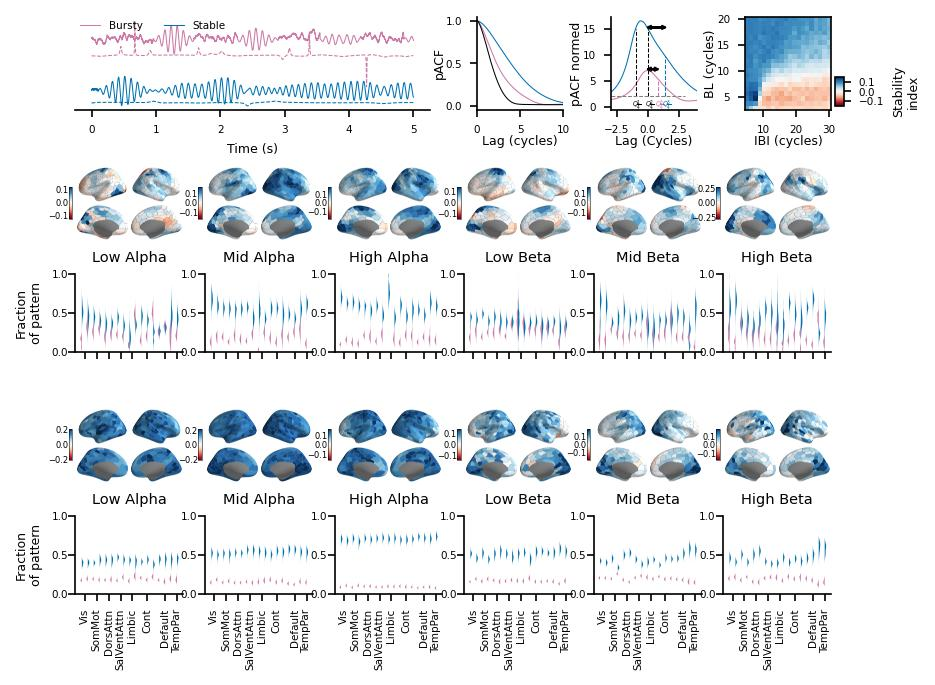

In [60]:
fig = plt.figure(figsize=(6.5, 5.0), dpi=150)

# main_spec = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1,2], hspace=0.25)

# top_spec = main_spec[0].subgridspec(nrows=1, ncols=6)
# bar_axes = [fig.add_subplot(top_spec[i]) for i in range(6)]

# brains_gs = main_spec[1].subgridspec(nrows=2, ncols=6)

# main_spec = fig.add_gridspec(nrows=4, ncols=6, hspace=0.25)
main_spec = fig.add_gridspec(nrows=3, ncols=1, hspace=0.35, height_ratios=[1,2,2])

top_spec = main_spec[0].subgridspec(ncols=6, nrows=1, wspace=0.55)
mid_spec = main_spec[1].subgridspec(ncols=6, nrows=2, hspace=0.4)
bot_spec = main_spec[2].subgridspec(ncols=6, nrows=2, hspace=0.4)

legend_elements = [Patch(facecolor=data_color, label='Stable'),
                   Patch(facecolor=red_color, label='Burst')]

top_axes = [fig.add_subplot(top_spec[:3]), fig.add_subplot(top_spec[3]), fig.add_subplot(top_spec[4]), fig.add_subplot(top_spec[5])]


top_axes[0].plot(np.arange(5000)/1000, burst_coeff_examples['bursty_signal'][:5000], color=ripples_red, lw=0.5, label='Bursty')
top_axes[0].plot(np.arange(4999)/1000, burst_coeff_examples['bursty_if'][:4999] - 30, color=ripples_red, ls='--', lw=0.5)

top_axes[0].plot(np.arange(5000)/1000, burst_coeff_examples['stable_signal'][:5000] - 65, color=ripples_blue, lw=0.5, label='Stable')
top_axes[0].plot(np.arange(4999)/1000, burst_coeff_examples['stable_if'][:5000] - 90, color=ripples_blue, ls='--', lw=0.5)

top_axes[1].plot(lags_cycles, burst_coeff_examples['bursty_pacf'], label='Bursty', color=ripples_red, lw=0.5)
top_axes[1].plot(lags_cycles, burst_coeff_examples['stable_pacf'], label='Stable', color=ripples_blue, lw=0.5)
top_axes[1].plot(lags_cycles, burst_coeff_examples['noise_pacf'], color='black', label='Baseline', lw=0.5)

top_axes[0].legend(frameon=False, fontsize=5, loc=(0.0, 0.8), ncol=2)

for arr, color in zip([bursty_pacf_normed, stable_pacf_normed], [ripples_red, ripples_blue]):
    segment = find_longest_segment(arr[:200] > 2)
    e_values = compute_e_values(arr[:200], threshold=2, interpolate=False) + segment[0]

    mask = (arr > 2)
    xt = np.arange(arr.shape[0]) - e_values[1]
    xt = xt / 10

    top_axes[2].plot(xt, arr, color=color, lw=0.5)
    top_axes[2].vlines((e_values[[2]] - e_values[1])/10, 2, arr[e_values[[2]]], color=color, ls='--', lw=0.5)

    top_axes[2].annotate('', (0, arr[e_values[1]] + 0.25), xytext=((e_values[2] - e_values[1])/10, arr[e_values[1]] + 0.25), arrowprops=dict(facecolor='black', width=0.05, headlength=1.5, headwidth=1.5))
    top_axes[2].annotate('', ((e_values[2] - e_values[1])/10, arr[e_values[1]] + 0.25), xytext=(0, arr[e_values[1]] + 0.25), arrowprops=dict(facecolor='black', width=0.05, headlength=1.5, headwidth=1.5))

    top_axes[2].annotate(r'$Q\frac{3}{4}$', ((e_values[[2]] - e_values[1])/10 - 0.25, 0.0), color=color, fontsize=3)

for label, pos in zip([r'$Q\frac{1}{4}$', r'$Q\frac{2}{4}$'], e_values):
    top_axes[2].annotate(label, ((pos - e_values[1])/10 - 0.25, 0.0), color='black', fontsize=3)

top_axes[2].vlines((e_values[[0,1]] - e_values[1])/10, 2, arr[e_values[[0,1]]], color='black', ls='--', lw=0.5)

top_axes[2].set_xlim(-3,4)
top_axes[2].hlines(2, -3, 3, color='gray', ls='--', lw=0.5)

imh = top_axes[3].pcolormesh(burst_coeff_examples['ibi_lags'], burst_coeff_examples['omega_burst_values'], burst_coeff_examples['stable_index_plane'], cmap='RdBu', vmax=0.15, vmin=-0.15)

# for ax, community_idx, band_name in zip(bar_axes, [2,3,4],['Low-alpha', 'High-alpha', 'Beta']):    
#     indices = seeg_comm_to_nodes[community_idx]
for modality_idx, modality_data in enumerate([[seeg_burst_fraction_boot, seeg_stable_fraction_boot],
                                              [meg_burst_fraction_boot.transpose(0,2,1), meg_stable_fraction_boot.transpose(0,2,1)]]):
    for community_idx, band_name in zip(range(6), ['Low Alpha', 'Mid Alpha', 'High Alpha', 'Low Beta', 'Mid Beta', 'High Beta']):    
        # indices = seeg_comm_to_nodes[community_idx]
        indices = seeg_communities_new[community_idx]

        if modality_idx == 0:
            ax = fig.add_subplot(mid_spec[1, community_idx])
        else:
            ax = fig.add_subplot(bot_spec[1, community_idx])

        for type_idx, (osc_type, osc_data, osc_color) in enumerate(zip(['Burst', 'Stable'], 
                                                #    [known_burst_fraction_boot, known_stable_fraction_boot],
                                                    modality_data,
                                                    [red_color, data_color])):
            osc_fraction = np.nanmean(osc_data[..., indices], axis=-1)
            osc_fraction_agg = npg.aggregate(subsystem_indices, osc_fraction, func='nanmean', axis=-1)
            # osc_fraction_agg = np.clip(osc_fraction_agg, *np.percentile(osc_fraction_agg, (2.5,97.5), axis=0))
            
            labels = None if type_idx == 1 else subsystem_to_index.keys()
            
            positions = np.arange(osc_fraction_agg.shape[-1])

            # parts = ax.violinplot(osc_fraction_agg, positions=positions,showextrema=False, showmeans=True)   
            # parts['cmeans'].set_color(osc_color)
            parts = ax.violinplot(osc_fraction_agg, positions=positions,showextrema=False, showmeans=False)   
            # parts['cmeans'].set_color(osc_color)

            for pc in parts['bodies']:
                pc.set_facecolor(osc_color)
                pc.set_alpha(1)
                # pc.set_edgecolor(osc_color)
                
                    
            for b in parts['bodies']:
                # get the center
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                violin_clip = (-np.inf, m) if type_idx == 0 else (m, np.inf)

                # modify the paths to not go further left than the center
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], *violin_clip)

        # ax.set_xticks(np.arange(17))
        ax.set_xticks(labels_grouped_indices)
        if modality_idx == 1:
            # ax.set_xticklabels(list(subsystem_to_index.keys()))
            ax.set_xticklabels(labels_grouped)
        else:
            ax.set_xticklabels([])
        ax.set_ylim([0,1.0])

        # ax.set_ylim([0,0.7])
        ax.tick_params(axis='x', rotation=90, labelsize=5)
        ax.tick_params(axis='y', labelsize=5, pad=0.1)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_title(band_name, fontsize=7)
        
        if community_idx == 0:
            ax.set_ylabel('Fraction\nof pattern', fontsize=6)
            
for band_idx, community_idx, band_name in zip(range(6), range(6), range(6)):  
    for modality_idx, modality, mapper, data, parcel_names in zip(range(2), 
                                ['SEEG', 'MEG', ], 
                                [seeg_communities_new,  meg_communities_new],
                                [known_burst_values,  avg_meg_burst_coeffs.T],
                                [seeg_parcel_names_new, meg_parcel_names]):
        is_seeg = (modality == 'SEEG')
        # indices = mapper[community_idx]
        # indices = sum([mapper[i] for i in community_idx], [])
        indices = mapper[community_idx]
        
        values = np.nanmean(data[:, indices], axis=-1)
        
        if is_seeg:
            values = smooth_adjacent_values(values, counter_known, adjacency_matrix)
#             values = np.clip(values,*np.nanpercentile(values, (1,99)))
            
        values -= 1
        cmap = 'RdBu'
        max_value = np.nanpercentile(np.abs(values), 97.5)
        min_value = -max_value
        
        if modality_idx == 0:
            views_gs =  mid_spec[0, band_idx].subgridspec(nrows=2, ncols=2, wspace=0.0, hspace=0.0)
        else:
            views_gs =  bot_spec[0, band_idx].subgridspec(nrows=2, ncols=2, wspace=0.0, hspace=0.0)

        views_axes = np.empty((2,2), dtype=object)
        
        for nr, nc in itertools.product(range(2), range(2)):
            views_axes[nr,nc] = fig.add_subplot(views_gs[nr,nc])
            
        draw_four_views(views_axes, values, parcel_names, brain_3d_surfaces, cmap='RdBu', norm_values=(min_value, max_value), 
                        cbar_ax_kwargs={'bbox_to_anchor': (-0.35,0.35,0.65,1.35)})
        # views_axes[0,0].set_title(modality + ' ' + str(band_name), x=1.15)
    

for ax, xlabel, ylabel in zip(top_axes[1:], ['Lag (cycles)', 'Lag (Cycles)', 'IBI (cycles)'], 
                              ['pACF', 'pACF normed', 'BL (cycles)']):
    ax.set_xlabel(xlabel, fontsize=6, labelpad=0.0)
    ax.set_ylabel(ylabel, fontsize=6, labelpad=0.0)

    ax.tick_params(axis='both', labelsize=5)

for ax in top_axes[1:3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

top_axes[1].set_xlim([0,10])

top_axes[0].spines['top'].set_visible(False)
top_axes[0].spines['right'].set_visible(False)
top_axes[0].spines['left'].set_visible(False)

top_axes[0].set_yticks([])
top_axes[0].set_xlabel('Time (s)', fontsize=6)

for ax in fig.axes[-56::5]:
    # ax.tick_params(axis='both', labelsize=5)
    ax.tick_params(labelsize=4, pad=0.1, left=False, length=0.0)

for ax in top_axes:
    ax.tick_params(axis='both', labelsize=5)

fig.tight_layout()

cax = top_axes[3].inset_axes([1.05, 0.05, 0.1, 0.3])
fig.colorbar(imh, cax=cax)

cax.tick_params(axis='both', labelsize=5)
cax.set_ylabel('Stability\nindex', fontsize=6)

# for ax, label in zip(fig.axes[:3], 
#                      string.ascii_lowercase):
#     ax.text(-0.15, 1, label, transform=ax.transAxes, fontsize=8)
    
# for ax, label in zip(fig.axes[3::5], 
#                      string.ascii_lowercase[3:]):
#     ax.text(-0.25, 1, label, transform=ax.transAxes, fontsize=8)
    
# fig.savefig('publication_figures/figure_burst.png', dpi=300)

C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\3166117941.py:60: RuntimeWarning: Mean of empty slice
  top_axes[2,0].semilogx(f_vals, np.nanmean(seeg_burst_values_boot, axis=(0,1)), color=ripples_blue, label='SEEG', lw=0.75)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\3166117941.py:61: RuntimeWarning: Mean of empty slice
  top_axes[2,0].semilogx(f_vals, np.nanmean(meg_burst_coeffs_boot, axis=(0,-1)), color=ripples_red, label='MEG', lw=0.75)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\3166117941.py:63: RuntimeWarning: Mean of empty slice
  top_axes[2,1].semilogx(f_vals, np.nanmean(seeg_burst_fraction_boot, axis=(0,1)), color=ripples_red, label='Burst', lw=0.75)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\3166117941.py:64: RuntimeWarning: Mean of empty slice
  top_axes[2,1].semilogx(f_vals, np.nanmean(seeg_stable_fraction_boot, axis=(0,1)), color=ripples_blue, label='Stable', lw=0.75)
C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\3166117941.py:66: 

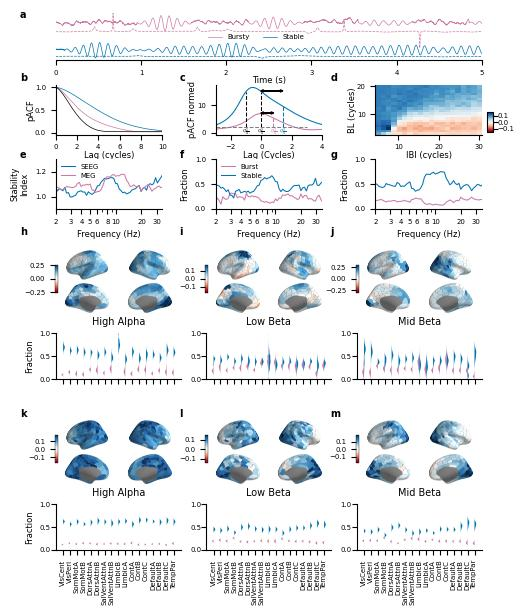

In [75]:
fig = plt.figure(figsize=(5.5, 7), dpi=100)

main_spec = fig.add_gridspec(nrows=3, ncols=1, hspace=0.25, height_ratios=[3,2,2])

top_spec = main_spec[0].subgridspec(ncols=3, nrows=3, wspace=0.5, hspace=0.5)
mid_spec = main_spec[1].subgridspec(ncols=3, nrows=2, hspace=0.3, height_ratios=[3,2])
bot_spec = main_spec[2].subgridspec(ncols=3, nrows=2, hspace=0.3, height_ratios=[3,2])

legend_elements = [Patch(facecolor=data_color, label='Stable'),
                   Patch(facecolor=red_color, label='Burst')]

top_axes = np.empty((3,3), dtype=object)

top_axes[0,0] = fig.add_subplot(top_spec[0, :3])

for i in range(1,3):
    for j in range(3):
        top_axes[i,j] = fig.add_subplot(top_spec[i,j])


top_axes[0,0].plot(np.arange(5000)/1000, burst_coeff_examples['bursty_signal'][:5000], color=ripples_red, lw=0.5, label='Bursty')
top_axes[0,0].plot(np.arange(4999)/1000, burst_coeff_examples['bursty_if'][:4999] - 30, color=ripples_red, ls='--', lw=0.5)

top_axes[0,0].plot(np.arange(5000)/1000, burst_coeff_examples['stable_signal'][:5000] - 65, color=ripples_blue, lw=0.5, label='Stable')
top_axes[0,0].plot(np.arange(4999)/1000, burst_coeff_examples['stable_if'][:5000] - 90, color=ripples_blue, ls='--', lw=0.5)

top_axes[1,0].plot(lags_cycles, burst_coeff_examples['bursty_pacf'], label='Bursty', color=ripples_red, lw=0.5)
top_axes[1,0].plot(lags_cycles, burst_coeff_examples['stable_pacf'], label='Stable', color=ripples_blue, lw=0.5)
top_axes[1,0].plot(lags_cycles, burst_coeff_examples['noise_pacf'], color='black', label='Baseline', lw=0.5)

top_axes[0,0].legend(frameon=False, fontsize=5, loc=(0.35, 0.35), ncol=2)
top_axes[0,0].set_xlim([0,5])

for arr, color in zip([bursty_pacf_normed, stable_pacf_normed], [ripples_red, ripples_blue]):
    segment = find_longest_segment(arr[:200] > 2)
    e_values = compute_e_values(arr[:200], threshold=2, interpolate=False) + segment[0]

    mask = (arr > 2)
    xt = np.arange(arr.shape[0]) - e_values[1]
    xt = xt / 10

    top_axes[1,1].plot(xt, arr, color=color, lw=0.75)
    top_axes[1,1].vlines((e_values[[2]] - e_values[1])/10, 2, arr[e_values[[2]]], color=color, ls='--', lw=0.75)

    top_axes[1,1].annotate('', (0, arr[e_values[1]] + 0.25), xytext=((e_values[2] - e_values[1])/10, arr[e_values[1]] + 0.25), arrowprops=dict(facecolor='black', width=0.05, headlength=1.5, headwidth=1.5))
    top_axes[1,1].annotate('', ((e_values[2] - e_values[1])/10, arr[e_values[1]] + 0.25), xytext=(0, arr[e_values[1]] + 0.25), arrowprops=dict(facecolor='black', width=0.05, headlength=1.5, headwidth=1.5))

    top_axes[1,1].annotate(r'$Q\frac{3}{4}$', ((e_values[[2]] - e_values[1])/10 - 0.25, 0.0), color=color, fontsize=3)

for label, pos in zip([r'$Q\frac{1}{4}$', r'$Q\frac{2}{4}$'], e_values):
    top_axes[1,1].annotate(label, ((pos - e_values[1])/10 - 0.25, 0.0), color='black', fontsize=3)

top_axes[1,1].vlines((e_values[[0,1]] - e_values[1])/10, 2, arr[e_values[[0,1]]], color='black', ls='--', lw=0.75)

top_axes[1,1].set_xlim(-3,4)
top_axes[1,1].hlines(2, -3, 3, color='gray', ls='--', lw=0.75)

imh = top_axes[1,2].pcolormesh(burst_coeff_examples['ibi_lags'], burst_coeff_examples['omega_burst_values'], burst_coeff_examples['stable_index_plane'], cmap='RdBu', vmax=0.15, vmin=-0.15)

top_axes[2,0].semilogx(f_vals, np.nanmean(seeg_burst_values_boot, axis=(0,1)), color=ripples_blue, label='SEEG', lw=0.75)
top_axes[2,0].semilogx(f_vals, np.nanmean(meg_burst_coeffs_boot, axis=(0,-1)), color=ripples_red, label='MEG', lw=0.75)

top_axes[2,1].semilogx(f_vals, np.nanmean(seeg_burst_fraction_boot, axis=(0,1)), color=ripples_red, label='Burst', lw=0.75)
top_axes[2,1].semilogx(f_vals, np.nanmean(seeg_stable_fraction_boot, axis=(0,1)), color=ripples_blue, label='Stable', lw=0.75)

top_axes[2,2].semilogx(f_vals, np.nanmean(meg_burst_fraction_boot, axis=(0,-1)), color=ripples_red, lw=0.75)
top_axes[2,2].semilogx(f_vals, np.nanmean(meg_stable_fraction_boot, axis=(0,-1)), color=ripples_blue, lw=0.75)

top_axes[2,0].legend(fontsize=5, frameon=False, loc=(0.025, 0.55))
top_axes[2,1].legend(fontsize=5, frameon=False, loc=(0.025, 0.55))


for modality_idx, modality_data in enumerate([[seeg_burst_fraction_boot, seeg_stable_fraction_boot],
                                              [meg_burst_fraction_boot.transpose(0,2,1), meg_stable_fraction_boot.transpose(0,2,1)]]):
    for col_idx, (community_idx, band_name) in enumerate(zip([2,3,4], [ 'High Alpha', 'Low Beta', 'Mid Beta'])):    
        # indices = seeg_comm_to_nodes[community_idx]

        if modality_idx == 0:
            indices = seeg_communities_new[community_idx]
        else:
            indices = meg_communities_new[community_idx]

        if modality_idx == 0:
            ax = fig.add_subplot(mid_spec[1, col_idx])
        else:
            ax = fig.add_subplot(bot_spec[1, col_idx])

        
        # top_axes[2, modality_idx].fill_betweenx([0, 0.8], f_vals[indices].min(), f_vals[indices].max(), alpha=0.2, color='blue')

        for type_idx, (osc_type, osc_data, osc_color) in enumerate(zip(['Burst', 'Stable'], 
                                                #    [known_burst_fraction_boot, known_stable_fraction_boot],
                                                modality_data,
                                                    [red_color, data_color])):
            osc_fraction = np.nanmean(osc_data[..., indices], axis=-1)
            osc_fraction_agg = npg.aggregate(subsystem_indices, osc_fraction, func='nanmean', axis=-1)
            # osc_fraction_agg = np.clip(osc_fraction_agg, *np.percentile(osc_fraction_agg, (2.5,97.5), axis=0))
            
            labels = None if type_idx == 1 else subsystem_to_index.keys()
            
            positions = np.arange(osc_fraction_agg.shape[-1])

            # parts = ax.violinplot(osc_fraction_agg, positions=positions,showextrema=False, showmeans=True)   
            # parts['cmeans'].set_color(osc_color)
            parts = ax.violinplot(osc_fraction_agg, positions=positions,showextrema=False, showmeans=False)   
            # parts['cmeans'].set_color(osc_color)

            for pc in parts['bodies']:
                pc.set_facecolor(osc_color)
                pc.set_alpha(1)
                # pc.set_edgecolor(osc_color)
                
                    
            for b in parts['bodies']:
                # get the center
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                violin_clip = (-np.inf, m) if type_idx == 0 else (m, np.inf)

                # modify the paths to not go further left than the center
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], *violin_clip)

        ax.set_xticks(np.arange(17))
        if modality_idx == 1:
            ax.set_xticklabels(list(subsystem_to_index.keys()))
        else:
            ax.set_xticklabels([])
        ax.set_ylim([0,1.0])

        # ax.set_ylim([0,0.7])
        ax.tick_params(axis='x', rotation=90, labelsize=5)
        ax.tick_params(axis='y', labelsize=5, pad=0.1)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_title(band_name, fontsize=7)
        
        if col_idx == 0:
            ax.set_ylabel('Fraction', fontsize=6)
            
for col_idx, community_idx, band_name in zip(range(3), [2,3,4], range(6)):  
    for modality_idx, modality, mapper, data, parcel_names in zip(range(2), 
                                ['SEEG', 'MEG', ], 
                                [seeg_communities_new,  meg_communities_new],
                                [seeg_burst_values_boot, meg_burst_coeffs_boot.transpose(0,2,1)],
                                [seeg_parcel_names_new, meg_parcel_names]):
        is_seeg = (modality == 'SEEG')
        # indices = mapper[community_idx]
        # indices = sum([mapper[i] for i in community_idx], [])
        indices = mapper[community_idx]
        
        values = np.nanmean(data[..., indices], axis=(0,-1))
        
        if is_seeg:
            values = smooth_adjacent_values(values, counter_known, adjacency_matrix)
#             values = np.clip(values,*np.nanpercentile(values, (1,99)))
            
        values -= 1
        cmap = 'RdBu'
        max_value = np.nanpercentile(np.abs(values), 97.5)
        min_value = -max_value
        
        if modality_idx == 0:
            views_gs =  mid_spec[0, col_idx].subgridspec(nrows=2, ncols=2, wspace=0.0, hspace=0.0)
        else:
            views_gs =  bot_spec[0, col_idx].subgridspec(nrows=2, ncols=2, wspace=0.0, hspace=0.0)

        views_axes = np.empty((2,2), dtype=object)
        
        for nr, nc in itertools.product(range(2), range(2)):
            views_axes[nr,nc] = fig.add_subplot(views_gs[nr,nc])
            
        draw_four_views(views_axes, values, parcel_names, brain_3d_surfaces, cmap='RdBu', norm_values=(min_value, max_value), 
                        cbar_ax_kwargs={'bbox_to_anchor': (-0.35,0.35,0.65,1.35)})
        # views_axes[0,0].set_title(modality + ' ' + str(band_name), x=1.15)
    

for ax, xlabel, ylabel in zip(top_axes[1], ['Lag (cycles)', 'Lag (Cycles)', 'IBI (cycles)'], 
                              ['pACF', 'pACF normed', 'BL (cycles)']):
    ax.set_xlabel(xlabel, fontsize=6, labelpad=0.1)
    ax.set_ylabel(ylabel, fontsize=6, labelpad=0.1)

    ax.tick_params(axis='both', labelsize=5)

for ax in top_axes[1:].flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax, ylim in zip(top_axes[2], [(0.9, 1.3),(0, 1),(0,1)]):
    ax.set_xlim([2,40])
    ax.set_ylim(ylim)

top_axes[1,0].set_xlim([0,10])

top_axes[0,0].spines['top'].set_visible(False)
top_axes[0,0].spines['right'].set_visible(False)
top_axes[0,0].spines['left'].set_visible(False)

top_axes[0,0].set_yticks([])
top_axes[0,0].set_xlabel('Time (s)', fontsize=6, labelpad=0.0)

for ax in filter(lambda x: type(x) is type(fig.axes[~0]), fig.axes):
    ax.tick_params(axis='both', labelsize=5)

for ax in filter(lambda x: not(x is None), top_axes.flatten()):
    ax.tick_params(axis='both', labelsize=5)

for ax, ylabel in zip(top_axes[2], ['Stability\nIndex', 'Fraction','Fraction']):
    ax.set_xlabel('Frequency (Hz)', fontsize=6)
    ax.set_ylabel(ylabel, fontsize=6)

    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.set_xticks([2,3,4,5,6,8,10,20,30, 50, 90])
    ax.set_xlim([2,35])

fig.tight_layout()

cax = top_axes[1,2].inset_axes([1.05, 0.05, 0.05, 0.4])
fig.colorbar(imh, cax=cax)

cax.tick_params(axis='both', labelsize=5, pad=0.0)
# cax.set_ylabel('SI', fontsize=5, labelpad=0.0)

cax.yaxis.set_ticks_position('right')
cax.yaxis.set_label_position('right')
# for ax, label in zip(fig.axes[:3], 
#                      string.ascii_lowercase):
#     ax.text(-0.15, 1, label, transform=ax.transAxes, fontsize=8)
    
# for ax, label in zip(fig.axes[3::5], 
#                      string.ascii_lowercase[3:]):
#     ax.text(-0.25, 1, label, transform=ax.transAxes, fontsize=8)

fig.text(0.06, 0.87, 'a', fontsize=7, weight='bold')

for label, (ypos, xpos) in zip(string.ascii_lowercase[1:], itertools.product([0.78, 0.67, 0.56, 0.3], [0.06, 0.35, 0.625])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')
    
fig.savefig('publication_figures/figure_7_burst.png', dpi=300)

In [43]:
for modality_idx, modality_data in enumerate([[seeg_burst_fraction_boot, seeg_stable_fraction_boot],
                                              [meg_burst_fraction_boot.transpose(0,2,1), meg_stable_fraction_boot.transpose(0,2,1)]]):
    for col_idx, (community_idx, band_name) in enumerate(zip([2,3,4], [ 'High Alpha', 'Low Beta', 'Mid Beta'])):    
        # indices = seeg_comm_to_nodes[community_idx]

        if modality_idx == 0:
            indices = seeg_communities_new[community_idx]
        else:
            indices = meg_communities_new[community_idx]
        
        # top_axes[2, modality_idx].fill_betweenx([0, 0.8], f_vals[indices].min(), f_vals[indices].max(), alpha=0.2, color='blue')

        for type_idx, (osc_type, osc_data, osc_color) in enumerate(zip(['Burst', 'Stable'], 
                                                #    [known_burst_fraction_boot, known_stable_fraction_boot],
                                                modality_data,
                                                    [red_color, data_color])):
            osc_fraction = np.nanmean(osc_data[..., indices], axis=-1)
            osc_fraction_agg = npg.aggregate(subsystem_indices, osc_fraction, func='nanmean', axis=-1)
            # osc_fraction_agg = np.clip(osc_fraction_agg, *np.percentile(osc_fraction_agg, (2.5,97.5), axis=0))

            labels = list(subsystem_to_index.keys())

            print(modality_idx, osc_type, band_name, labels[osc_fraction_agg.mean(axis=0).argmax()])


C:\Users\vlamyr\AppData\Local\Temp\2\ipykernel_35756\4017339610.py:17: RuntimeWarning: Mean of empty slice
  osc_fraction = np.nanmean(osc_data[..., indices], axis=-1)


0 Burst High Alpha SalVentAttnB
0 Stable High Alpha LimbicB
0 Burst Low Beta LimbicB
0 Stable Low Beta SomMotA
0 Burst Mid Beta ContC
0 Stable Mid Beta VisPeri
1 Burst High Alpha ContA
1 Stable High Alpha ContC
1 Burst Low Beta SomMotB
1 Stable Low Beta DefaultC
1 Burst Mid Beta SomMotB
1 Stable Mid Beta DefaultC
